# EE 267 Project coding by Anika Zaman, Id: 015955082

In [1]:
#Code by Anika Zaman
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')
import tensorflow.compat.v1 as tf

In [2]:
path = 'lung-and-colon-cancer-histopathological-images\lung_colon_image_set\lung_colon_image_sets'
classes = os.listdir(path)
classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

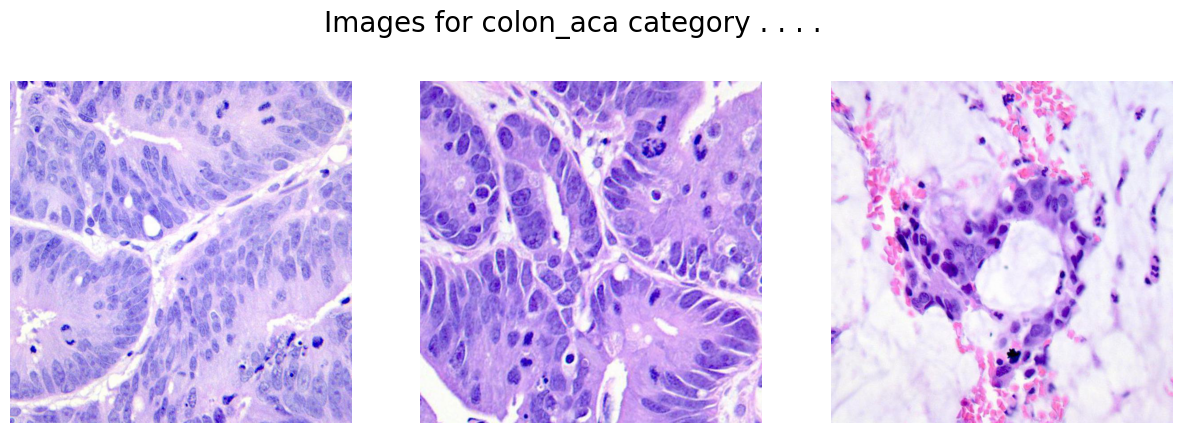

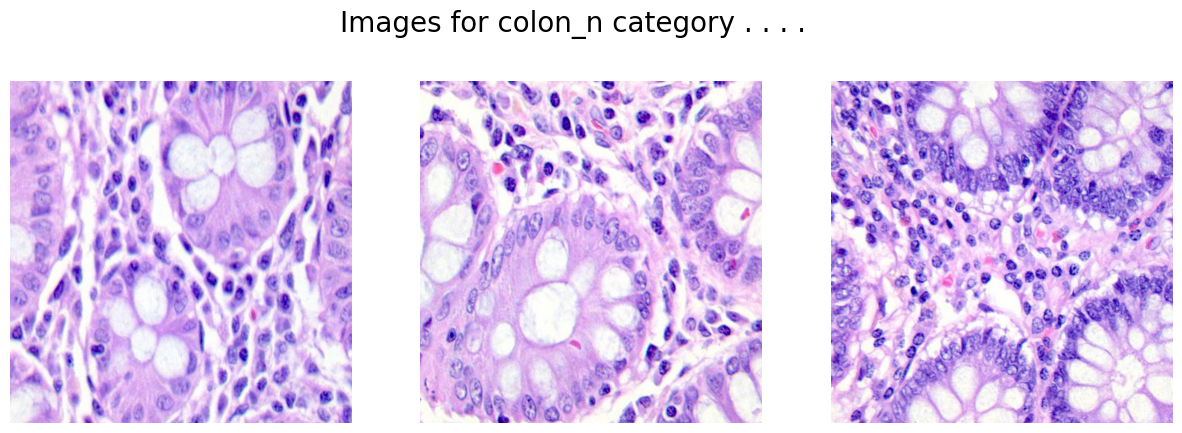

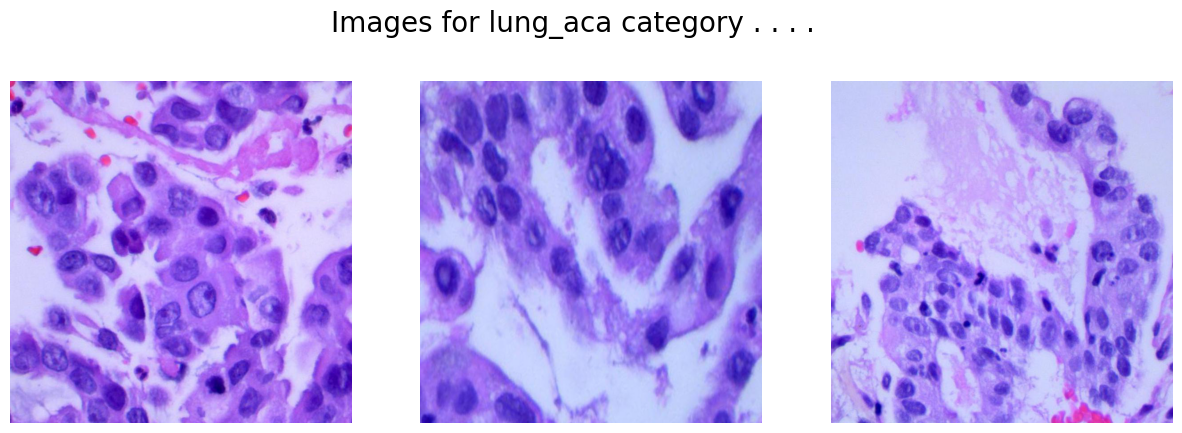

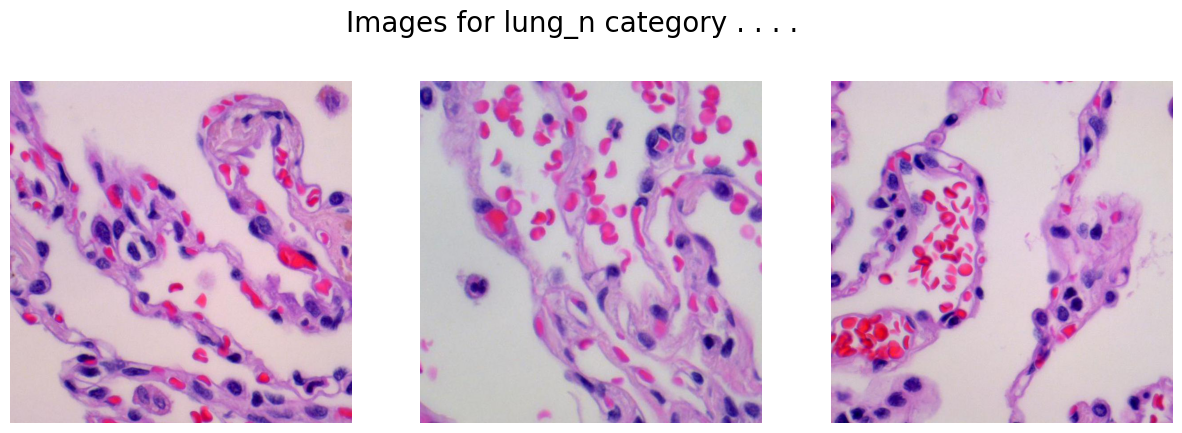

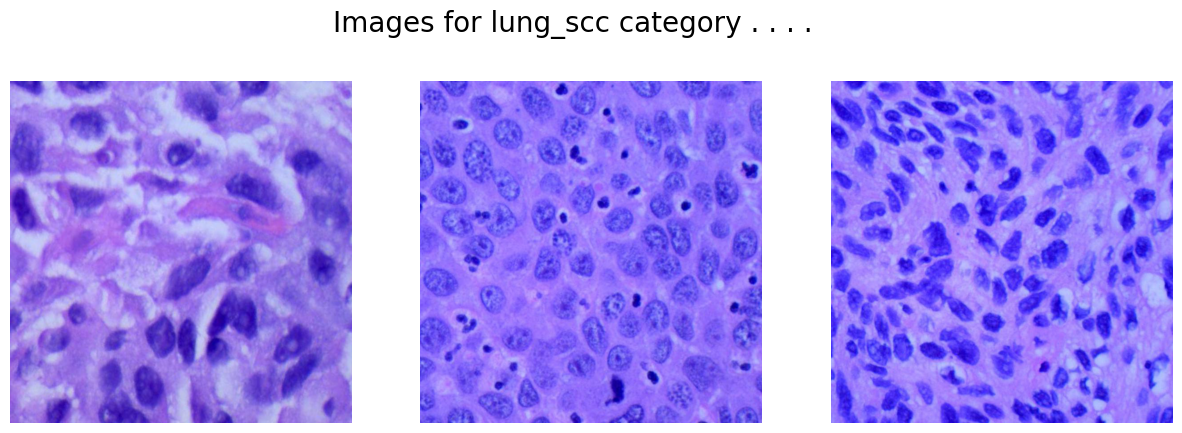

In [3]:
path = 'lung-and-colon-cancer-histopathological-images\lung_colon_image_set\lung_colon_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [4]:
IMG_SIZE = 224
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 16 #changed from 64 to 32

In [6]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(20000, 224, 224, 3) (5000, 224, 224, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 224  # Change this to your desired image size

import os
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Create a new ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))  # Adjust based on the number of classes



94765736/94765736 [==============================] - 18s 0us/step


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 24145797 (92.11 MB)
Trainable params: 24092677 (91.91 MB)
Non-trainable params: 53120 (207.50 KB)
__________

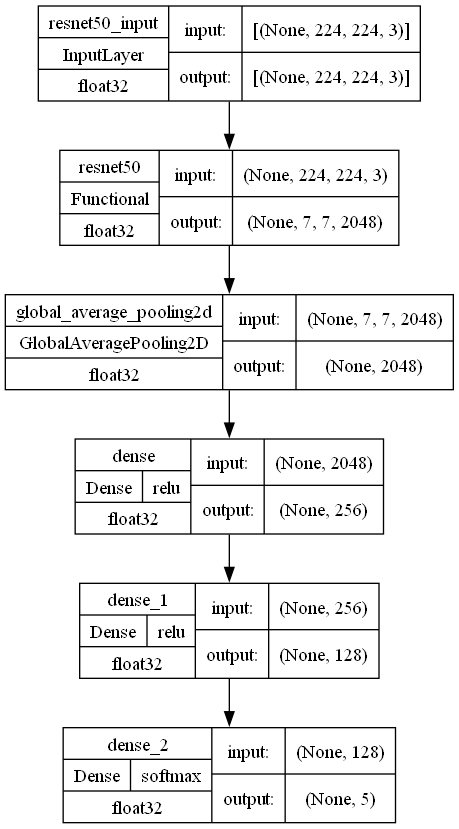

In [10]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.99:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [12]:
# Import the necessary modules
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras.optimizers import Adam  # Assuming you're using Adam optimizer

# Compile the model
model.compile(optimizer=Adam(),  # Use the Adam optimizer (or choose another)
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Now you can proceed with training
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size= 32,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])


Epoch 1/10


625/625 [==============================] - 6230s 10s/step - loss: 0.2421 - accuracy: 0.9238 - val_loss: 0.1937 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 6774s 11s/step - loss: 0.1110 - accuracy: 0.9599 - val_loss: 0.1609 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 6629s 11s/step - loss: 0.0824 - accuracy: 0.9701 - val_loss: 0.2334 - val_accuracy: 0.9134 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9726
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 [==============================] - 6355s 10s/step - loss: 0.0956 - accuracy: 0.9726 - val_loss: 0.2184 - val_accuracy: 0.9306 - lr: 0.0010


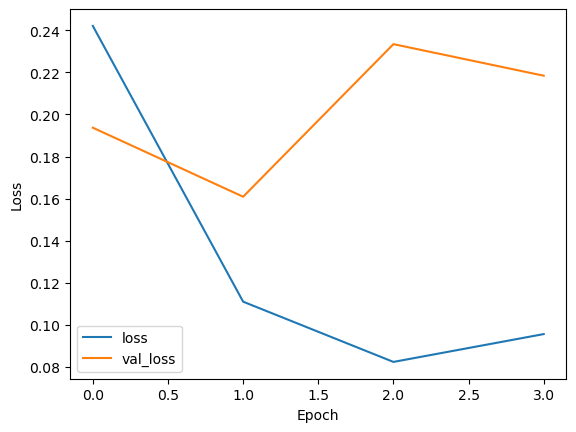

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.show()

In [14]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

157/157 [==============================] - 425s 3s/step


In [15]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[967,   0,   0,   0,   0],
       [136, 883,   0,   0,   0],
       [  7,   0, 915,   2,  86],
       [  1,   0,  32, 966,   0],
       [  3,   0,  49,   0, 953]], dtype=int64)

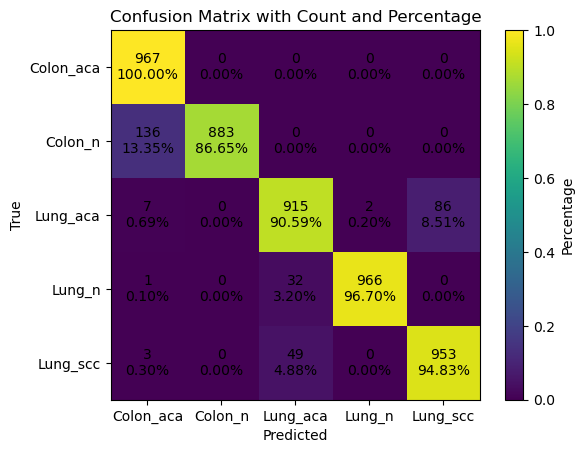

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Provided confusion matrix
conf_matrix = np.array([[967,   0,   0,   0,   0],
       [136, 883,   0,   0,   0],
       [  7,   0, 915,   2,  86],
       [  1,   0,  32, 966,   0],
       [  3,   0,  49,   0, 953]])

# Calculate normalized confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Define class labels
classes = ['Colon_aca', 'Colon_n', 'Lung_aca', 'Lung_n', 'Lung_scc']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as a heatmap with 'viridis' colormap
cax = ax.imshow(conf_matrix_norm, cmap='viridis', vmin=0, vmax=1)

# Display count and percentage in each cell
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count_value = conf_matrix[i, j]
        percent_value = conf_matrix_norm[i, j]
        ax.text(j, i, f'{count_value}\n{percent_value:.2%}', ha='center', va='center', color='black')

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label('Percentage')

# Set labels and title
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Count and Percentage')

plt.show()


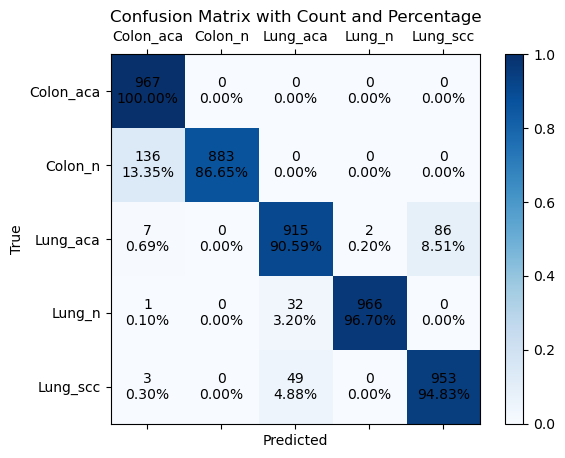

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Provided confusion matrix
conf_matrix = np.array([[967,   0,   0,   0,   0],
       [136, 883,   0,   0,   0],
       [  7,   0, 915,   2,  86],
       [  1,   0,  32, 966,   0],
       [  3,   0,  49,   0, 953]])
# Calculate normalized confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Define class labels
classes = ['Colon_aca', 'Colon_n', 'Lung_aca', 'Lung_n', 'Lung_scc']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix
cax = ax.matshow(conf_matrix_norm, cmap='Blues')

# Display count and percentage in each cell
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count_value = conf_matrix[i, j]
        percent_value = conf_matrix_norm[i, j]
        ax.text(j, i, f'{count_value}\n{percent_value:.2%}', ha='center', va='center', color='black')

# Add colorbar
fig.colorbar(cax)

# Set labels and title
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Count and Percentage')

plt.show()



In [18]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

   Colon_aca       0.87      1.00      0.93       967
     Colon_n       1.00      0.87      0.93      1019
    Lung_aca       0.92      0.91      0.91      1010
      Lung_n       1.00      0.97      0.98       999
    Lung_scc       0.92      0.95      0.93      1005

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



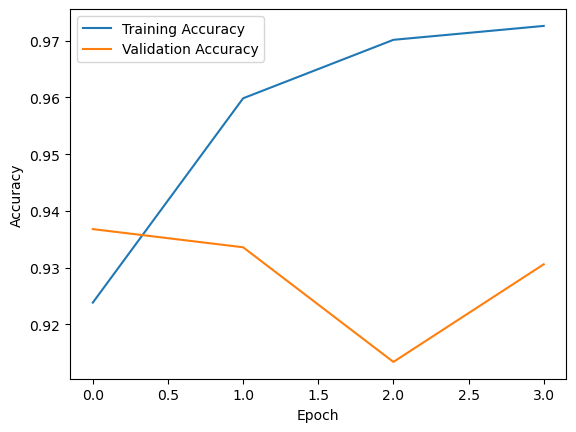

In [19]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
x = (history.history['accuracy'])
print(x)
print(x[3])

[0.9238499999046326, 0.959850013256073, 0.9701499938964844, 0.972599983215332]
0.972599983215332


In [21]:
y = (history.history['loss'])
print(y)
print(y[3])

[0.24206550419330597, 0.1110435202717781, 0.08241699635982513, 0.09564551711082458]
0.09564551711082458


In [22]:
import pandas as pd

# Example parameter data
parameters = {'accuracy': x[3], 'loss': y[3]}

# Create a DataFrame
df = pd.DataFrame([parameters])

# Specify the CSV file path
csv_file_path = 'EE267_resNet_parameters25000.csv'

# Save DataFrame to CSV
df.to_csv(csv_file_path, index=False)

print(f'Parameter data saved to {csv_file_path}')

Parameter data saved to EE267_resNet_parameters25000.csv


157/157 [==============================] - 465s 3s/step
Lung_aca
0
Lung_n
1
Colon_n
2
Colon_n
3
Colon_aca
4


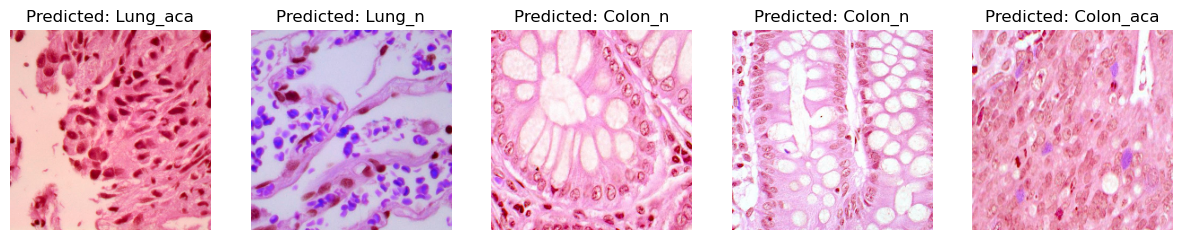

In [23]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load your dataset and prepare the data as per your original script

# Assuming you have a trained model named 'model'
# Use the model to predict classes for validation data
predictions = model.predict(X_val)

# Choose 5 random indices
random_indices = np.random.choice(X_val.shape[0], 5, replace=False)

# Plot the original images with randomly selected actual classes
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    # Original image
    original_img = X_val[idx]
    
    # Randomly select an actual class from ground truth labels
    actual_class = Y_val[idx].argmax()
    
    # Predicted class probabilities
    class_probabilities = predictions[idx]
    
    # Predicted class index
    predicted_class = np.argmax(class_probabilities)
    
    # Display the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_img)
    plt.title(f'Predicted: {classes[predicted_class]}')
    print(classes[predicted_class])
    print(i)
    plt.axis('off')

plt.show()
